# Preprocesamiento de Datos
Una vez disponemos de nuestra partición de entrenamiento, vamos a comenzar con el preprocesamiento de los datos.
Dadas las características de nuestros datos, los puntos principales que tendremos que abordar serán:
* Codificación de atributos de tipo string.
* Estrategias de imputación de valores ausentes.
* Selección de características (dado que el conjunto de atributos es elevado).
* Desbalanceo de clases

## Codificación de atributos de tipo string
Vemos que en nuestro dataset tenemos dos atributos que además de ser redundantes son de tipo string. De estos dos campos vamos a eliminar uno de ellos y el restante lo codificaremos de manera numérica.


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [2]:
# Cargamos nuestro dataset de entrenamiento
data_train = pd.read_csv('../particiones/train_original.csv', sep=';', na_values='', decimal=',')

# Cargamos nuestro dataset de test
data_test = pd.read_csv('../particiones/test_original.csv', sep=';', na_values='', decimal=',')

In [3]:
# Eliminamos el atributo "Country" y codificamos numéricamente el campo "Code"
data_train.drop(['Country'], axis=1, inplace=True)
data_test.drop(['Country'], axis=1, inplace=True)
le = LabelEncoder()
data_train['Code'] = le.fit_transform(data_train['Code'])
data_test['Code'] = le.transform(data_test['Code'])

In [4]:
# Presentamos la tabla de correpondencias para posible futuro uso
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'AFG': 0, 'AGO': 1, 'ALB': 2, 'ARE': 3, 'ARG': 4, 'ARM': 5, 'ATG': 6, 'AUS': 7, 'AUT': 8, 'AZE': 9, 'BDI': 10, 'BEL': 11, 'BEN': 12, 'BFA': 13, 'BGD': 14, 'BGR': 15, 'BHR': 16, 'BHS': 17, 'BIH': 18, 'BLR': 19, 'BLZ': 20, 'BOL': 21, 'BRA': 22, 'BRB': 23, 'BRN': 24, 'BTN': 25, 'BWA': 26, 'CAF': 27, 'CAN': 28, 'CHE': 29, 'CHL': 30, 'CHN': 31, 'CIV': 32, 'CMR': 33, 'COD': 34, 'COG': 35, 'COL': 36, 'COM': 37, 'CPV': 38, 'CRI': 39, 'CYP': 40, 'CZE': 41, 'DEU': 42, 'DJI': 43, 'DMA': 44, 'DNK': 45, 'DOM': 46, 'DZA': 47, 'ECU': 48, 'EGY': 49, 'ERI': 50, 'ESP': 51, 'EST': 52, 'ETH': 53, 'FIN': 54, 'FJI': 55, 'FRA': 56, 'FSM': 57, 'GAB': 58, 'GBR': 59, 'GEO': 60, 'GHA': 61, 'GIN': 62, 'GMB': 63, 'GNB': 64, 'GNQ': 65, 'GRC': 66, 'GRD': 67, 'GTM': 68, 'GUY': 69, 'HND': 70, 'HRV': 71, 'HTI': 72, 'HUN': 73, 'IDN': 74, 'IND': 75, 'IRL': 76, 'IRN': 77, 'IRQ': 78, 'ISL': 79, 'ISR': 80, 'ITA': 81, 'JAM': 82, 'JOR': 83, 'JPN': 84, 'KAZ': 85, 'KEN': 86, 'KGZ': 87, 'KHM': 88, 'KIR': 89, 'KNA': 90, 'KOR': 9

## Eliminación de atributos correlacionados

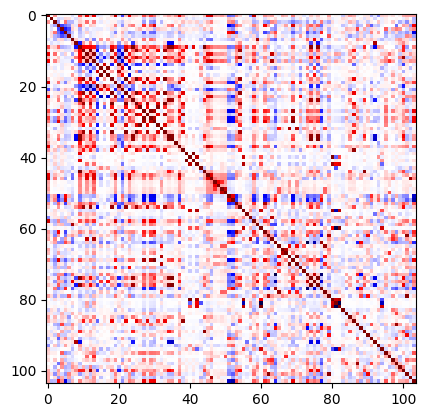

[ 12  13  17  20  22  24  25  29  31  33  34  35  41  44  69  70  73  74
  76  80  81  82  86  89 101]
['General government net debt (National currency)', 'General government net debt (Percent of GDP)', 'General government primary net lending/borrowing (Percent of GDP)', 'General government structural balance (National currency)', 'General government total expenditure (National currency)', 'Gross domestic product based on purchasing-power-parity (PPP) (share of world total Percent)', 'Gross domestic product corresponding to fiscal year, current prices (National currency)', 'Gross domestic product per capita, current prices Purchasing power parity; (international dollars)', 'Gross domestic product, constant prices (National currency)', 'Gross domestic product, current prices (National currency)', 'Gross domestic product, current prices Purchasing power parity; (international dollars)', 'Gross domestic product, current prices (U.S. dollars)', 'Inflation, end of period consumer prices (In

In [5]:
import matplotlib.pyplot as plt

R = data_train.corr()
plt.imshow(R, cmap='seismic')
plt.show()

corr_th = 0.9
idx = abs(R) > corr_th
mts = np.triu(idx,1)
rows, cols = np.where(mts==True)

id_corr = np.unique(cols)
print(id_corr)
corr_cols = list(data_train.iloc[:, id_corr].columns)
print(corr_cols)
print(data_train.shape)
data_train.drop(axis=1, columns=corr_cols, inplace=True)
print(data_train.shape)

print(data_test.shape)
data_test.drop(axis=1, columns=corr_cols, inplace=True)
print(data_test.shape)

### Imputación de Valores Ausentes
Vamos a plantear tres posibles estrategias para la imputación de valores ausentes:
* Eliminación de registros.
* Imputación por el valor medio.
* Uso de algoritmo K-Nearest Neighbors.

Para cada caso crearemos un nuevo dataset a partir de nuestro dataset de entrenamiento para su uso en fases posteriores.

Sin embargo, antes de proceder a la imputación de los datos como tal, hay un problema adicional que tenemos que tratar: como hemos podido observar tenemos atributos para los cuales el volumen global de valores ausentes es muy elevado. No tiene sentido mantener estas características porque o bien acabarían provocando tener que eliminar todos los registros porque todas las instancias tendrían algún valor nulo entre sus características, o bien los valores de imputación serán básicamente siempre los mismos por lo que el nivel de varianza y por tanto la utilidad predictiva será prácticamente nula.

Por ello vamos a eliminar todas aquellos atributos que tengan un porcentaje de valores ausentes superior al 30%.

In [6]:
# Presentamos los volúmenes de datos originales
print(f'Datos Entrenamiento: {data_train.shape}')
etiquetas = ['No Crisis', 'Pre-Crisis', 'Crisis/Post-Crisis']
_, ocurrencias_train = np.unique(data_train['Crisis'], return_counts=True)
print(f'Distribución de Muestras Entrenamiento:{etiquetas} - {ocurrencias_train}')

print(f'Datos Test: {data_test.shape}')
_, ocurrencias_test = np.unique(data_test['Crisis'], return_counts=True)
print(f'Distribución de Muestras Test:{etiquetas} - {ocurrencias_test}')


Datos Entrenamiento: (6956, 79)
Distribución de Muestras Entrenamiento:['No Crisis', 'Pre-Crisis', 'Crisis/Post-Crisis'] - [3593 1006 2357]
Datos Test: (1692, 79)
Distribución de Muestras Test:['No Crisis', 'Pre-Crisis', 'Crisis/Post-Crisis'] - [953 208 531]


In [7]:
# Eliminamos los atributos con volumen de valores ausentes > 30%
def eliminarAtributos(data):
    num_ausentes = data.isna().sum()
    porcentaje = round(num_ausentes / data.shape[0] * 100, 2)
    porcentaje = porcentaje[porcentaje>30]
    print(f'Número de Atributos eliminados: {len(porcentaje)}')
    print(f'Porcentaje Máximo: {np.max(porcentaje)}')
    print(f'Porcentaje Mínimo: {np.min(porcentaje)}')
    return list(porcentaje.index)

In [8]:
# Obtenemos los atributos a eliminar en base a los datos de entrenamiento
lista_atributos = eliminarAtributos(data_train)

# Eliminamos las columnas en entrenamiento y test
data_train.drop(axis=1, columns=lista_atributos, inplace=True)
data_test.drop(axis=1, columns=lista_atributos, inplace=True)

# Presentamos los nuevos volúmenes de datos
print(f'Datos Entrenamiento: {data_train.shape}')
etiquetas = ['No Crisis', 'Pre-Crisis', 'Crisis/Post-Crisis']
_, ocurrencias_train = np.unique(data_train['Crisis'], return_counts=True)
print(f'Distribución de Muestras Entrenamiento:{etiquetas} - {ocurrencias_train}')

print(f'Datos Test: {data_test.shape}')
_, ocurrencias_test = np.unique(data_test['Crisis'], return_counts=True)
print(f'Distribución de Muestras Test:{etiquetas} - {ocurrencias_test}')


Número de Atributos eliminados: 41
Porcentaje Máximo: 87.08
Porcentaje Mínimo: 30.38
Datos Entrenamiento: (6956, 38)
Distribución de Muestras Entrenamiento:['No Crisis', 'Pre-Crisis', 'Crisis/Post-Crisis'] - [3593 1006 2357]
Datos Test: (1692, 38)
Distribución de Muestras Test:['No Crisis', 'Pre-Crisis', 'Crisis/Post-Crisis'] - [953 208 531]


In [9]:
# Eliminación de registros: borraremos todos aquellos registros para los que alguno de los valores de los atributos no esté presente
train_deleted = data_train.dropna(axis=0, how='any', inplace=False)
test_deleted = data_test.dropna(axis=0, how='any', inplace=False)

# Presentamos los nuevos volúmenes de datos tras eliminar los registros
print(train_deleted.shape)
_, ocurrencias_train = np.unique(train_deleted['Crisis'], return_counts=True)
print(f'Distribución de Muestras de Entrenamiento:{etiquetas} - {ocurrencias_train}')

print(test_deleted.shape)
_, ocurrencias_test = np.unique(test_deleted['Crisis'], return_counts=True)
print(f'Distribución de Muestras de Test:{etiquetas} - {ocurrencias_test}')

(2040, 38)
Distribución de Muestras de Entrenamiento:['No Crisis', 'Pre-Crisis', 'Crisis/Post-Crisis'] - [695 373 972]
(825, 38)
Distribución de Muestras de Test:['No Crisis', 'Pre-Crisis', 'Crisis/Post-Crisis'] - [441 119 265]


In [10]:
# Imputación de valores ausentes por valor medio
from sklearn.impute import SimpleImputer

train_media = data_train.copy()
test_media = data_test.copy()

imp = SimpleImputer(strategy='mean') # Utilizamos la estrategia de la media
train_media = imp.fit_transform(train_media.to_numpy(na_value=np.nan))
test_media = imp.transform(test_media.to_numpy(na_value=np.nan))

print(train_media.shape)
print(test_media.shape)

(6956, 38)
(1692, 38)


In [11]:
# Imputación de valores ausentes mediante KNN
from sklearn.impute import KNNImputer

train_knn = data_train.copy()
test_knn = data_test.copy()

knn_imp = KNNImputer()
train_knn = knn_imp.fit_transform(train_knn.to_numpy(na_value=np.nan))
test_knn = knn_imp.transform(test_knn.to_numpy(na_value=np.nan))

print(train_knn.shape)
print(test_knn.shape)

(6956, 38)
(1692, 38)
